# **Menyiapkan Package**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# **Menyiapkan Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset Info
base_dir = '/content/drive/MyDrive/Capstone/Recommendation System'
df_dir = 'dummy_plant_data.csv'
df_dir = os.path.join(base_dir, df_dir)
dataset = pd.read_csv(df_dir)

# Showing first 5 data
print(dataset.head())

      Plant  Temp  Humidity
0  Kangkung    24        70
1    Pakcoy    23        70
2     Bayam    20        52
3  Kangkung    27        79
4    Selada    27        65


# **Pre-Processing Data**

## Analisis Distribusi Dataset

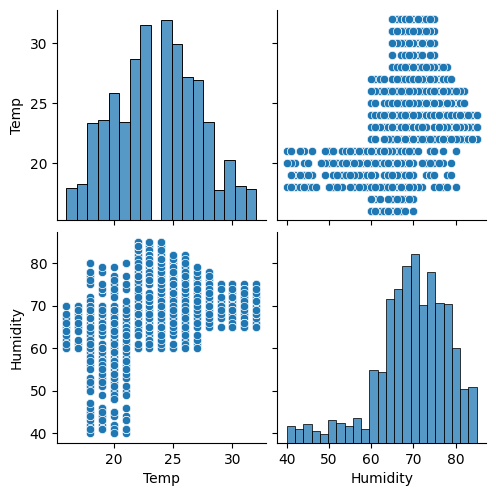

In [ ]:
sns.pairplot(dataset[[ 'Temp', 'Humidity']])

<ipython-input-5-1a5df5480b73>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[x] , bins = 15)
<ipython-input-5-1a5df5480b73>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[x] , bins = 15)


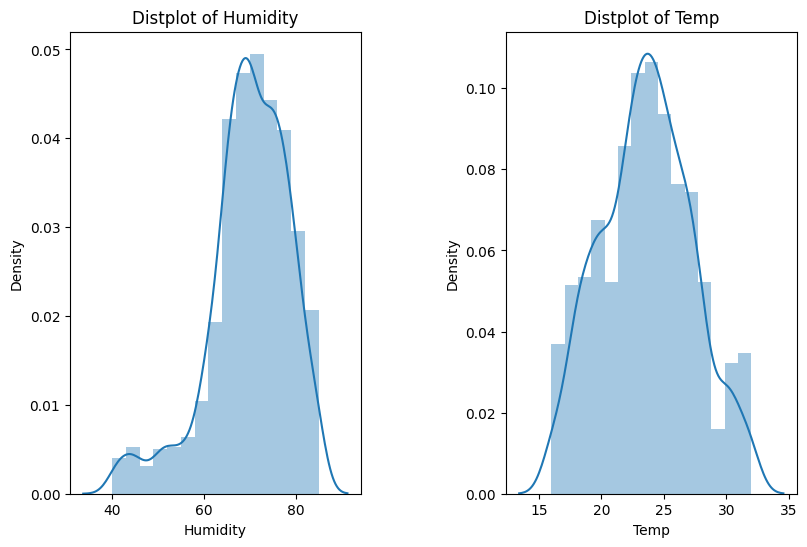

In [ ]:
plt.figure(1 , figsize = (15 , 6))
n = 0
for x in ['Humidity' , 'Temp' ]:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(dataset[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

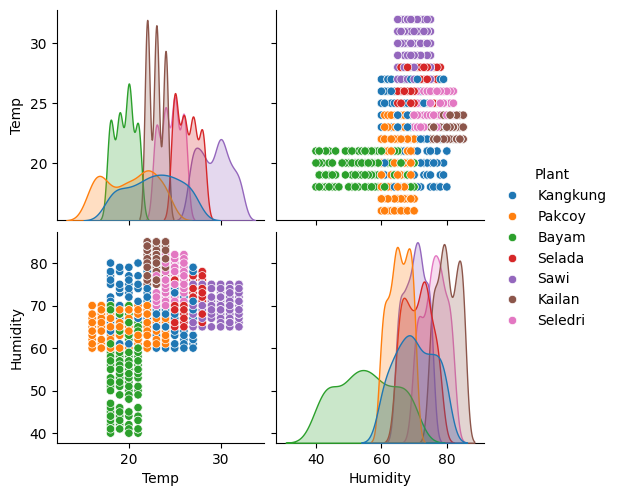

In [ ]:
# Distribusi Tiap Jenis Tanaman
sns.pairplot(dataset, vars = ['Temp', 'Humidity'], hue = "Plant")

## Analisis Korelasi

In [ ]:
dataset[['Temp', 'Humidity']].corr()

,Temp,Humidity
Temp,1.000000,0.354428
Humidity,0.354428,1.000000


<Axes: >

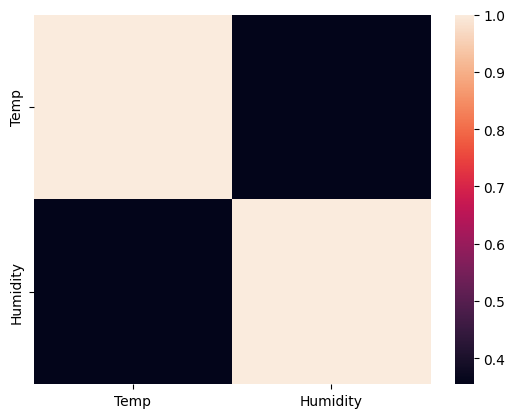

In [ ]:
sns.heatmap(dataset[['Temp', 'Humidity']].corr())

## Analisis Outlier

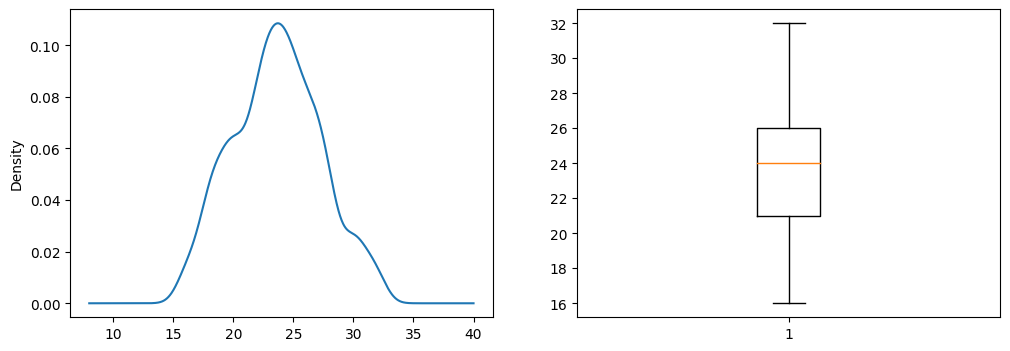

In [ ]:
# Distribusi Variabel Temperatur
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
dataset['Temp'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(dataset['Temp'])

plt.show()

<Axes: xlabel='Temp'>

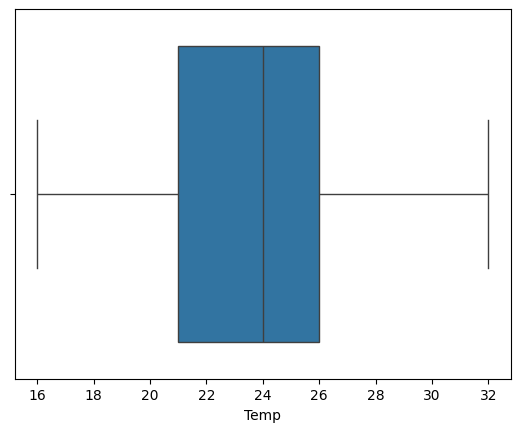

In [ ]:
sns.boxplot(x=dataset['Temp'])

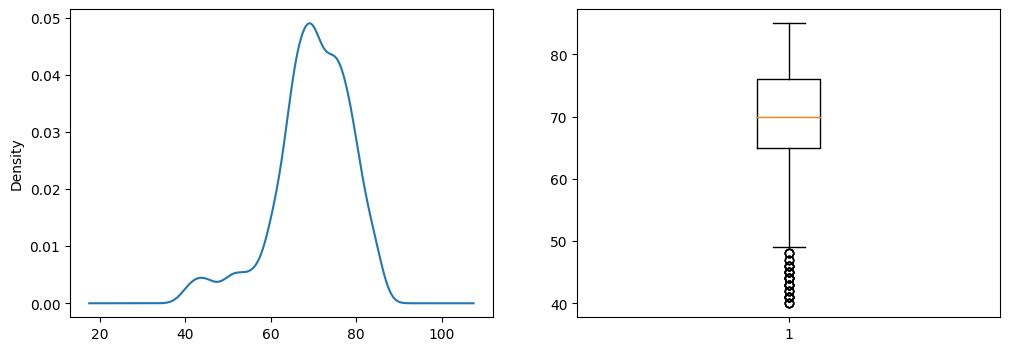

In [ ]:
# Distribusi Variabel Kelembaban
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
dataset['Humidity'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(dataset['Humidity'])

plt.show()

<Axes: xlabel='Humidity'>

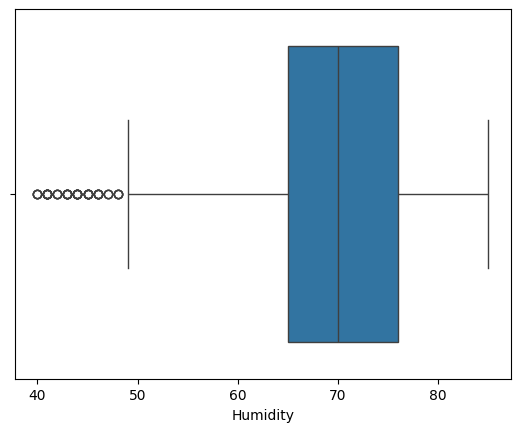

In [ ]:
# Boxplot Variabel Kelembaban
sns.boxplot(x=dataset['Humidity'])

## Imputasi Data Outlier

In [ ]:
# Statistik Deskriptif Variabel Kelembaban
Q1 = dataset['Humidity'].quantile(0.25)
Q3 = dataset['Humidity'].quantile(0.75)
IQR = Q3 - Q1

boxplot_min = Q1 - 1.5 * IQR
boxplot_max = Q3 + 1.5 * IQR

print('Q1:\n',Q1)
print('\nQ3:\n',Q3)
print('\nIQR:\n',IQR)
print('\nMin:\n',boxplot_min)
print('\nMax:\n',boxplot_max)

Q1:
 65.0

Q3:
 76.0

IQR:
 11.0

Min:
 48.5

Max:
 92.5


In [ ]:
# Subset DataFrame Tanpa Outlier
filter_min = dataset['Humidity']<boxplot_min
filter_max = dataset['Humidity']>boxplot_max

new_df = dataset[~(filter_min|filter_max)]
new_df.shape

(1348, 3)

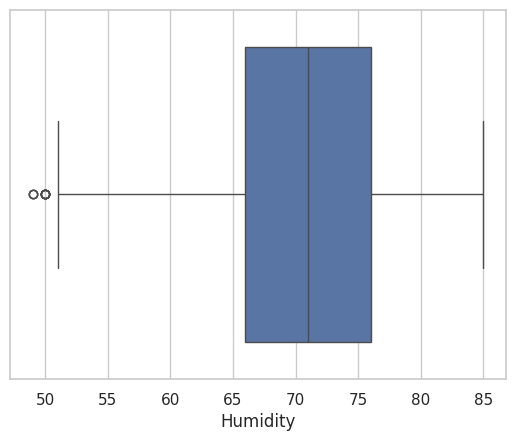

In [ ]:
# Boxplot Subset DataFrame Tanpa Outlier
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=new_df['Humidity'])

In [ ]:
# Menyalin DataFrame Subset
new_df = new_df.copy()

In [ ]:
# Jumlah Kemunculan Setiap Nilai Unik Plants dalam Setiap Kolom DataFrame
new_df.value_counts()

Plant     Temp  Humidity
Kailan    22    83          13
                79          12
          23    80          11
                85          11
                76          10
                            ..
Kangkung  21    64           1
          20    79           1
                77           1
                76           1
Sawi      28    68           1
Name: count, Length: 492, dtype: int64

In [ ]:
new_df.tail()

,Plant,Temp,Humidity
1395,Kailan,24,81
1396,Kailan,23,80
1397,Sawi,31,66
1398,Pakcoy,22,66
1399,Bayam,18,57


In [ ]:
# Jumlah Nilai Unik Setiap Kolom DataFrame
for feat in new_df.columns:
    hh = new_df.groupby(feat)['Plant'].count()
    print(feat,',', 'Unique :',len(new_df[feat].unique()))

Plant , Unique : 7
Temp , Unique : 17
Humidity , Unique : 37


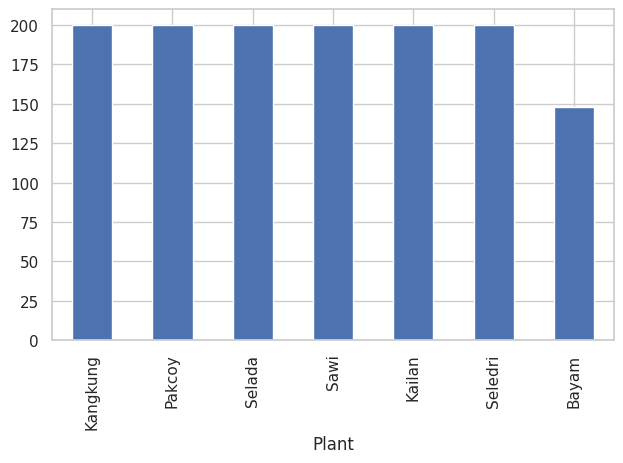

In [ ]:
# Frekuensi Jenis Tanaman dalam DataFrame
new_df['Plant'].value_counts().plot.bar()
plt.tight_layout()
plt.show()

## Mengatasi Ketidakseimbangan Kelas

In [ ]:
pip install imbalanced-learn scikit-learn

In [ ]:
# Memisahkan fitur dan target
X = new_df[['Temp', 'Humidity']]
y = new_df['Plant']

# Menerapkan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Membuat DataFrame Baru Setelah SMOTE
df_resampled = pd.DataFrame(X_res, columns=['Temp', 'Humidity'])
df_resampled['Plant'] = y_res

# Menampilkan jumlah sampel setelah SMOTE
print("\nJumlah sampel setelah SMOTE:")
print(y_res.value_counts())


Jumlah sampel setelah SMOTE:
Plant
Kangkung    200
Pakcoy      200
Bayam       200
Selada      200
Sawi        200
Kailan      200
Seledri     200
Name: count, dtype: int64


## Pemisahan Data Train dan Validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10)

print('training dataset:')
print(X_train.shape)
print(y_train.shape)
print()
print('testing dataset:')
print(X_test.shape)
print(y_test.shape)

training dataset:
(1120, 2)
(1120,)

testing dataset:
(280, 2)
(280,)


# **Analisis K-Means**

## Menentukan Jumlah Klaster

In [ ]:
df_resampled = df_resampled.drop(['Plant'],axis=1)

### Analisis Jumlah Klaster Metode Skor Siluet

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

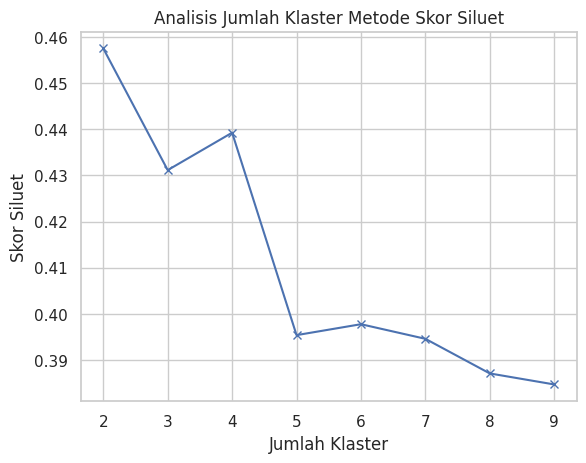

In [ ]:
# Inisialisasi List untuk Skor Siluet Tiap Jumlah Klaster
silhouette_scores = []

# Inisialisasi Range Percobaan Jumlah Klaster
k_range = range(2, 10)

# Analisis Klaster Variabel Plant dan Perhitungan Skor Siluet
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_resampled)
    labels = kmeans.labels_
    score = silhouette_score(df_resampled, labels)
    silhouette_scores.append(score)

# Visualisasi Skor Siluet
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Skor Siluet')
plt.title('Analisis Jumlah Klaster Metode Skor Siluet')
plt.show()

### Analisis Jumlah Klaster Metode Elbow

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

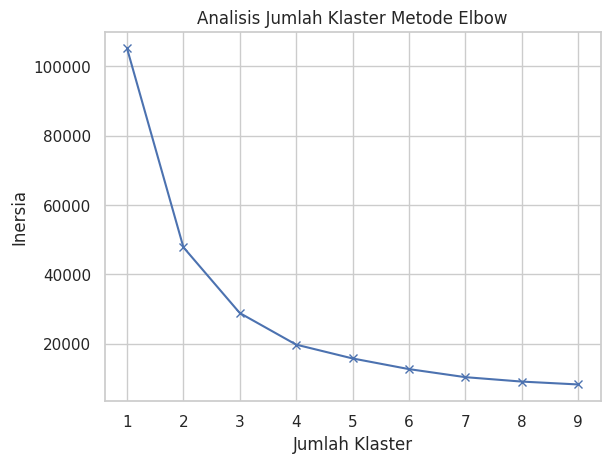

In [ ]:
# Inisialisasi List untuk Nilai Inersia Tiap Jumlah Klaster
inertia = []

# Inisialisasi Range Percobaan Jumlah Klaster
k_range = range(1, 10)

# Analisis Klaster Variabel Plant dan Perhitungan Nilai Inersia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_resampled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Inersia')
plt.title('Analisis Jumlah Klaster Metode Elbow')
plt.show()

## Analisis K-Means

In [ ]:
# Inisialisasi Jumlah Klaster
n_clusters = 4 # Berdasarkan metode skor siluet, skor turun signifikan setelah klaster keempat

# Inisialisasi Model K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Melatih Model dengan Data Tanaman
kmeans.fit(X_res)

# Matriks Centroid Klaster
centers = kmeans.cluster_centers_

# Inisialisasi Nilai Inersia K-Means
inertia = kmeans.inertia_

# Prediksi Klaster Tanaman
labels = kmeans.labels_

print("Centroids Klaster:")
print(centers)

print("Inertia:", inertia)

# Print Klaster untuk Setiap Tanaman
print("\nKluster untuk Setiap Data Tanaman:")
for i, label in enumerate(labels):
    print(f"Data {i+1}: Cluster {label+1}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centroids Klaster:
[[23.62556054 78.75336323]
 [20.47978437 65.17520216]
 [27.19914347 70.31049251]
 [19.34482759 53.67241379]]
Inertia: 19755.765672411027

Kluster untuk Setiap Data Tanaman:
Data 1: Cluster 3
Data 2: Cluster 3
Data 3: Cluster 4
Data 4: Cluster 1
Data 5: Cluster 3
Data 6: Cluster 3
Data 7: Cluster 2
Data 8: Cluster 3
Data 9: Cluster 3
Data 10: Cluster 2
Data 11: Cluster 1
Data 12: Cluster 2
Data 13: Cluster 2
Data 14: Cluster 3
Data 15: Cluster 3
Data 16: Cluster 2
Data 17: Cluster 1
Data 18: Cluster 3
Data 19: Cluster 3
Data 20: Cluster 3
Data 21: Cluster 1
Data 22: Cluster 1
Data 23: Cluster 1
Data 24: Cluster 2
Data 25: Cluster 1
Data 26: Cluster 2
Data 27: Cluster 3
Data 28: Cluster 1
Data 29: Cluster 2
Data 30: Cluster 2
Data 31: Cluster 1
Data 32: Cluster 3
Data 33: Cluster 3
Data 34: Cluster 3
Data 35: Cluster 3
Data 36: Cluster 1
Data 37: Cluster 1
Data 38: Cluster 4
Data 39: Cluster 1
Data 40: Cluster 3
Data 41: Cluster 1
Data 42: Cluster 3
Data 43: Cluster 3


In [ ]:
# Inisialisasi Variabel untuk Label
df_resampled['Plant'] = y_res

## Visualisasi Tanaman terhadap Temperatur dan Kelembaban Berdasarkan Klaster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


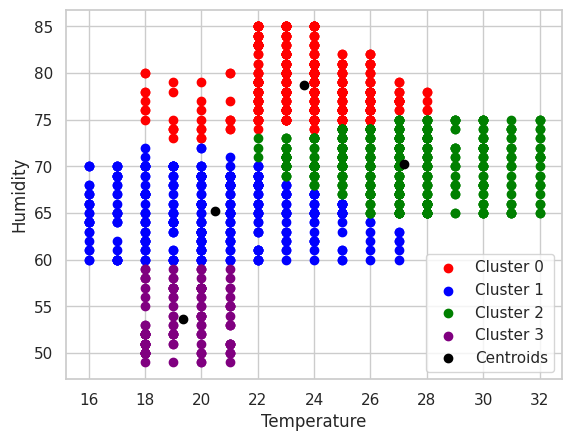

In [ ]:
import matplotlib.pyplot as plt
import pickle

# Fit k-Means pada dataset
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_res)

# Mengambil label cluster yang telah dipredisksi
y_kmeans = kmeans.predict(X_res)

# Membuat scatter plot
plt.scatter(X_res[y_kmeans == 0]['Temp'], X_res[y_kmeans == 0]['Humidity'], c='red', label='Cluster 0')
plt.scatter(X_res[y_kmeans == 1]['Temp'], X_res[y_kmeans == 1]['Humidity'], c='blue', label='Cluster 1')
plt.scatter(X_res[y_kmeans == 2]['Temp'], X_res[y_kmeans == 2]['Humidity'], c='green', label='Cluster 2')
plt.scatter(X_res[y_kmeans == 3]['Temp'], X_res[y_kmeans == 3]['Humidity'], c='purple', label='Cluster 3')

# Ploting centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', label='Centroids')

# Menambahkan label untuk sumbu x dan y
plt.xlabel('Temperature')
plt.ylabel('Humidity')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Pemodelan K-Means

In [ ]:
filename = f'kmeans_model.pickle'

# Menyimpan Model Klaster K-Means
pickle.dump(kmeans, open(filename, "wb"))
print(f'Model Kmeans berhasil disimpan dengan nama {filename}')

Model Kmeans berhasil disimpan dengan nama kmeans_model.pickle


In [ ]:
# Membuat DataFrame Baru dari Setiap Klaster
df_clusters = df_resampled.copy()
df_clusters['cluster'] = y_kmeans

# Memisahkan DataFrame Setiap Klaster
cluster_dfs = {}
for cluster_label in range(kmeans.n_clusters):
    cluster_dfs[cluster_label] = df_clusters[df_clusters['cluster'] == cluster_label].drop('cluster', axis=1)

# Print Labels Setiap Klaster
for cluster_label, cluster_df in cluster_dfs.items():
    print(f"Cluster {cluster_label}:")
    labels = cluster_df['Plant'].unique()
    print("Plant:", labels)
    print("=============================")

Cluster 0:
Plant: ['Kangkung' 'Kailan' 'Seledri' 'Selada']
Cluster 1:
Plant: ['Pakcoy' 'Kangkung' 'Bayam' 'Selada']
Cluster 2:
Plant: ['Kangkung' 'Pakcoy' 'Selada' 'Sawi' 'Seledri']
Cluster 3:
Plant: ['Bayam']


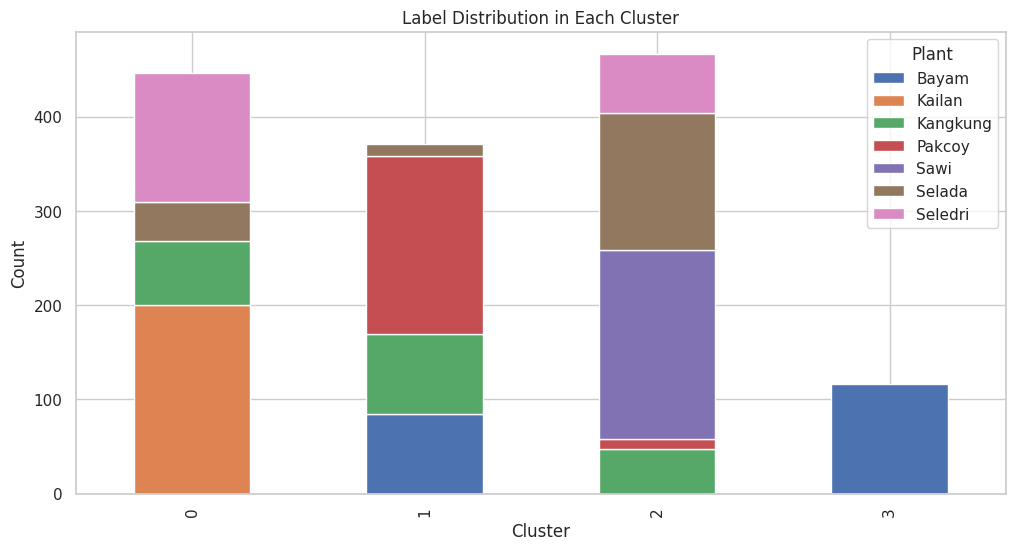

In [ ]:
# Visualisasi Bar Plot untuk Distribusi Label pada Setiap Klaster
cluster_counts = df_clusters.groupby(['cluster', 'Plant']).size().unstack()
cluster_counts.plot(kind='bar', stacked=True)

plt.title('Label Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.show()

In [ ]:
# Export Setiap Klaster Menjadi DataFrame Baru
for cluster_label in df_clusters['cluster'].unique():
    cluster_df = df_clusters[df_clusters['cluster'] == cluster_label]
    cluster_df.to_csv(f'cluster_{cluster_label}.csv', index=False)

In [ ]:
file_names = ['cluster_0.csv', 'cluster_1.csv', 'cluster_2.csv', 'cluster_3.csv']

# Inisialisasi Dictionary untuk Menyimpan DataFrame Tiap cluster
dataframes = {}

# Perulangan untuk membaca dan membuat DataFrame untuk setiap cluster
for cluster_file in file_names:
    # Membaca file CSV dan membuat DataFrame
    df = pd.read_csv(cluster_file)

    # Menyimpan DataFrame ke dalam dictionary dengan key sesuai nama cluster
    cluster_name = cluster_file.split('.')[0]  # Mengambil nama cluster dari nama file
    dataframes[cluster_name] = df

# DataFrame untuk cluster_0
df_cluster_0 = dataframes['cluster_0']
print("DataFrame untuk cluster_0:")
print(df_cluster_0.head())

# DataFrame untuk cluster_1
df_cluster_1 = dataframes['cluster_1']
print("\nDataFrame untuk cluster_1:")
print(df_cluster_1.head())

# DataFrame untuk cluster_2
df_cluster_2 = dataframes['cluster_2']
print("\nDataFrame untuk cluster_2:")
print(df_cluster_2.head())

# DataFrame untuk cluster_3
df_cluster_3 = dataframes['cluster_3']
print("\nDataFrame untuk cluster_3:")
print(df_cluster_3.head())

DataFrame untuk cluster_0:
   Temp  Humidity     Plant  cluster
0    27        79  Kangkung        0
1    22        79    Kailan        0
2    22        78  Kangkung        0
3    24        79   Seledri        0
4    20        74  Kangkung        0

DataFrame untuk cluster_1:
   Temp  Humidity   Plant  cluster
0    16        65  Pakcoy        1
1    18        62  Pakcoy        1
2    19        70  Pakcoy        1
3    17        64  Pakcoy        1
4    24        62  Pakcoy        1

DataFrame untuk cluster_2:
   Temp  Humidity     Plant  cluster
0    24        70  Kangkung        2
1    23        70    Pakcoy        2
2    27        65    Selada        2
3    25        70    Selada        2
4    29        72      Sawi        2

DataFrame untuk cluster_3:
   Temp  Humidity  Plant  cluster
0    20        52  Bayam        3
1    19        53  Bayam        3
2    19        52  Bayam        3
3    18        51  Bayam        3
4    21        55  Bayam        3


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pickle

def classify_clusters(cluster_data):
    highest_accuracy = 0.0
    best_cluster = None

    for cluster_name, cluster_df in cluster_data.items():
        # Mengambil Fitur dan Label dari DataFrame
        X = cluster_df.drop('Plant', axis=1)
        y = cluster_df['Plant']

        # Membuat Model Decision Tree Classifier
        model = DecisionTreeClassifier()

        # Melakukan Pelatihan Model
        model.fit(X, y)

        filename = f'model_{cluster_name}.pickle'

        # Menyimpan Model Tiap Klaster
        pickle.dump(model, open(filename, "wb"))
        print(f'Model {filename} berhasil disimpan')

        # Melakukan Prediksi Berdasarkan Model
        y_pred = model.predict(X)

        # Menghitung Akurasi Model
        accuracy = accuracy_score(y, y_pred)

        print(accuracy)

        # Membandingkan Akurasi dengan Nilai Tertinggi Sejauh Ini
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_cluster = cluster_name

    # Mengembalikan DataFrame dengan nilai akurasi tertinggi
    return cluster_data[best_cluster]

# Memanggil Fungsi classify_clusters untuk cluster_0, cluster_1, cluster_2, dan cluster_3
dataframes = {'cluster_0': df_cluster_0, 'cluster_1': df_cluster_1, 'cluster_2': df_cluster_2, 'cluster_3': df_cluster_3}
best_cluster_df = classify_clusters(dataframes)

print("DataFrame dengan nilai akurasi tertinggi:")
print(best_cluster_df.head())

Model model_cluster_0.pickle berhasil disimpan
0.7556053811659192
Model model_cluster_1.pickle berhasil disimpan
0.738544474393531
Model model_cluster_2.pickle berhasil disimpan
0.7408993576017131
Model model_cluster_3.pickle berhasil disimpan
1.0
DataFrame dengan nilai akurasi tertinggi:
   Temp  Humidity  Plant  cluster
0    20        52  Bayam        3
1    19        53  Bayam        3
2    19        52  Bayam        3
3    18        51  Bayam        3
4    21        55  Bayam        3


## Contoh Implementasi Model

In [ ]:
# Input variabel temperature & humidity
input = [[23,65]]

In [ ]:
# Load model clustering
filename = 'kmeans_model.pickle'
loaded_kmeans_model = pickle.load(open(filename, "rb"))

# Eksekusi model
predict_cluster = loaded_kmeans_model.predict(input)

# Mengambil label cluster
predict_cluster_int = predict_cluster[0]

# Menambahkan label cluster kedalam var input untuk proses
input[0].append(predict_cluster_int)


print(f'Cluster {predict_cluster_int}')
print(input[0])

Cluster 1
[23, 65, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [ ]:
# Load model klasifikasi
filename = f'model_cluster_{predict_cluster_int}.pickle'
loaded_model = pickle.load(open(filename, "rb"))

# Eksekusi model klasifikasi
predict_cluster = loaded_model.predict(input)

print(f'Cluster {predict_cluster_int}')
print(f'Tanaman hidroponik yang disarankan adalah tanaman {predict_cluster[0].lower()}.')

print(input)

Cluster 1
Tanaman hidroponik yang disarankan adalah tanaman pakcoy.
[[23, 65, 1]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
